<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/ArchISPE_fullPackage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries if not already installed
!pip install contractions colorama rouge-score swifter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 10.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5b9ab5905ae90a23cd285be26ddb0ce0797cf7c547764779af5009656ba13163
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=e72eb54f264830835e0d3eda33bb1fc6e34e8e573e5ac25c453fca9c194720f0
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built rouge-score swifter


In [ ]:
# Importing libraries
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import string
from nltk.tokenize import sent_tokenize
import re
from rouge_score import rouge_scorer
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
import torch.optim as optim
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from ipywidgets import widgets



# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Initialize Lemmatizer and NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Initialize tokenizer and model from 'jeniya/BERTOverflow'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("jeniya/BERTOverflow")
model = AutoModel.from_pretrained("jeniya/BERTOverflow").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/660k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/596M [00:00<?, ?B/s]

## Debugging

In [ ]:
#text = dataset['processed_question'].iloc[0]  # Get a sample question
#tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")  # Tokenize
#print(f"Tokenized Text Shape: {tokens['input_ids'].shape}")

# I. Post Preprocessing Layer

In [ ]:
# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Apply the function to 'Question_body' and 'Answer_body' columns

dataset = pd.read_excel('366_ARPs_for_extracting_Issue_Solution_Pairs.xlsx')

dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].apply(clean_html)
dataset['Answer_body_cleaned'] = dataset['Answer_body_cleaned'].apply(clean_html)

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

In [ ]:
dataset[['Question_body_cleaned', 'Answer_body_cleaned']].head()

,Question_body_cleaned,Answer_body_cleaned
0,I need help with the architecture pattern I sh...,So first of all what we're talking about here ...
1,which part of file structure we should do proc...,"For the purpose of clean architecture, the fro..."
2,I am building c# .NET 4.8.1 MVC web applicatio...,There is no easy and reliable way to do this w...
3,We have a mobile application that we scale as ...,There is not a simple answer to this question....
4,I'm trying to properly design an application a...,Determining the source of the information is b...


## Lemmatization, Stopword Removal

In [ ]:
lemmatizer = WordNetLemmatizer()

# Preprocess text
def preprocess_text(text):
    sentences = sent_tokenize(text)
    stop_words = set(ENGLISH_STOP_WORDS)
    processed_sentences = []
    for sentence in sentences:
        # Tokenization and cleaning
        words = re.findall(r'\b\w+\b', sentence.lower())
        words = [word for word in words if word not in stop_words and word.isalpha()]
        # Lemmatization
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        processed_sentences.append(" ".join(lemmatized_words))  # Store sentence as string
    return sentences, processed_sentences

# Preprocess question and answer bodies
dataset['processed_question'] = dataset['Question_body_cleaned'].apply(preprocess_text)
dataset['processed_answer'] = dataset['Answer_body_cleaned'].apply(preprocess_text)

# II. Feature Extraction Layer

---



## Contextual features extractor: Get BERT embeddings from BERTOverflow

In [ ]:
# Define BERTOverflow embedding extraction
def get_bert_embeddings(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings from the [CLS] token for each sentence
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Get mean of token embeddings for each sentence
    return embeddings.cpu().numpy()

# Get BERT embeddings from preprocessed question and answer text
dataset['question_embeddings'] = dataset['processed_question'].apply(lambda x: get_bert_embeddings(x[1]))
dataset['answer_embeddings'] = dataset['processed_answer'].apply(lambda x: get_bert_embeddings(x[1]))


## Debugging: Check shape of embeddings in the first 3 rows

In [ ]:

for i in range(3):
    emb = dataset['question_embeddings'].iloc[i]
    print(f"Row {i} - question embedding shape: {emb.shape}")


Row 0 - question embedding shape: (15, 768)
Row 1 - question embedding shape: (5, 768)
Row 2 - question embedding shape: (10, 768)


In [ ]:
# Example: Check shape of first sentence embedding in first row
first_sentence_vector = dataset['question_embeddings'].iloc[0][0]
print("Shape of one sentence vector:", first_sentence_vector.shape)


Shape of one sentence vector: (768,)


In [ ]:
# Ensure all sentence embeddings are the same size (should be 768 for BERT)
vector_sizes = dataset['question_embeddings'].apply(lambda x: [vec.shape[0] for vec in x])
print(vector_sizes.tolist())


[[768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768], [768, 768, 768, 768], [768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768], [768, 768, 768, 768, 7

## Local Feature Extractor: Using the TextCNN Model for feature extraction


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define TextCNN model with adjusted kernel sizes
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, filter_sizes=[2, 2, 2], num_filters=100, num_classes=256):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (filter_size, embedding_dim)) for filter_size in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        x = x.unsqueeze(1)  # Add channel dimension for conv layer (batch_size, 1, seq_length, embedding_dim)

        # Apply convolution and remove the last dimension
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # Shape becomes (batch_size, num_filters, seq_length)

        # Apply max pooling over the sequence length dimension
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # Shape becomes (batch_size, num_filters)

        x = torch.cat(x, 1)  # Concatenate pooled outputs (batch_size, num_filters * len(filter_sizes))
        x = self.fc(x)  # Fully connected layer
        return x

# Define a function to extract TextCNN features
def extract_textcnn_features(sentences, model, tokenizer, device):
    # Tokenize and pad the sentences for TextCNN
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model(inputs['input_ids'])  # Extract learned TextCNN features from tokenized input
    return features.cpu().numpy()

# Initialize TextCNN model with the adjusted kernel sizes
vocab_size = len(tokenizer.vocab)  # do this if tokenizer is defined
embedding_dim = 256  # embedding dimension
textcnn_model = TextCNN(vocab_size, embedding_dim, filter_sizes=[2, 2, 2], num_classes=256).to(device)


## Domain-Specific, Linguistic patterns, Heuristic Feature Extraction

In [ ]:
# Define fucntion for question_thread Domain-Specific, Heuristic, Linguistic Feature Extraction
def q_extract_domain_specific_linguistic_patterns_heuristic_features(sentence, architectural_keywords, fiveW1H_keywords_question, linguistic_patterns):
    features = {'contains_architecture_keywords': 0, 'contains_question_words': 0, 'contains_linguistic_patterns': 0}
    for keyword in architectural_keywords:
        if keyword.lower() in sentence.lower():
            features['contains_architecture_keywords'] = 1
            break
    for keyword in fiveW1H_keywords_question:
        if keyword.lower() in sentence.lower():
            features['contains_question_words'] = 1
            break
    for pattern in linguistic_patterns:
        if pattern.lower() in sentence.lower():
            features['contains_linguistic_patterns'] = 1
            break
    return features

############################################################################################################################
# Define fucntion for answer_thread Domain-Specific, Heuristic, Linguistic Feature Extraction
def a_extract_domain_specific_linguistic_patterns_heuristic_features(sentence, architectural_keywords, linguistic_patterns):
    features = {'contains_architecture_keywords': 0, 'contains_linguistic_patterns': 0}
    for keyword in architectural_keywords:
        if keyword.lower() in sentence.lower():
            features['contains_architecture_keywords'] = 1
            break
    for pattern in linguistic_patterns:
        if pattern.lower() in sentence.lower():
            features['contains_linguistic_patterns'] = 1
            break
    return features


In [ ]:
# List of architectural keywords categorized for clarity
architectural_keywords = {
    "Architectural Patterns and Styles": [
        "Architecture pattern", "Design pattern", "MVC", "Model View Controller", "Monolith",
        "Microservice", "microservices", "MVP", "Model View Presenter", "MVVP",
        "Model View ViewModel", "MVVM", "Client-Server", "Client Server", "Client/Server",
        "Layered pattern", "N-Tier", "Event Driven pattern", "Event Driven",
        "Pipe and Filter", "Service Oriented Architecture", "SOA", "Broker", "Peer to Peer",
        "Master-Slave", "Master and Slave", "Blackboard", "Command Query Responsibility Segregation", "CQRS"
        "Hexagonal Architecture", "Hexagonal", "Publish–Subscribe", "Publish and Subscribe", "Event Sourcing",
        "Reactive Architecture", "Database Per Service", "Pipe-and-Filter with Feedback Loops",
        "Saga Pattern", "Service Mesh Architecture", "Strangler Fig Pattern",
        "Multi-Tenant Architecture", "Actor Model", "Interpreter Architecture",
        "Pipeline Architecture", "Digital Twin Architecture", "User Interface"
        "Monolithic", "Event-Driven", "Hybrid Architecture", "Clean Architecture"
    ],

    "Architectural Tactics": [
        "Architecture tactic", "Design tactic", "Heartbeat", "Checkpoint", "Checkpointing",
        "Retry Mechanism", "Failover Mechanism", "Load Balancing", "Caching", "Concurrency",
        "Queue-Based Load Management", "Data Compression", "Lazy Loading", "Authentication",
        "Authorization", "Data Encryption", "Intrusion Detection", "Audit Logging",
        "Firewalls", "API Gateways", "Cache", "Caching","Loose coupling","Resource Pooling",
        "Failover"
    ],

    "Software Design Principles": [
        "Encapsulation", "Separation of Concerns", "Abstraction",
        "Component-Based Design", "Refactoring", "Plug-in Architecture"
    ],

    "Scalability and Performance Optimization": [
        "Horizontal Scaling", "Scale-Out", "Vertical Scaling", "Scale-Up",
        "Sharding", "Database Replication", "Progressive Disclosure","Server Replication",
        "Undo Mechanism", "Redo Mechanism", "Event-Bus Pattern"
    ],

    "Reliability and Fault Tolerance": [
        "Consistent UI Design", "Removal from service", "Exception Prevention",
        "Introduce Concurrency", "Maintain Multiple Copies of Data", "Bound Queue Sizes",
        "Schedule Resources", "Manage Resources", "Manage Sampling Rate", "Limit Event Response",
        "Prioritize Events", "Bound Execution Times", "Increase Resource Efficiency"
    ],

    "Networking and Communication": [
        "REST", "SOAP", "WCF", "Ping/Echo", "Ping and Echo","Shadow", "Active Redundancy", "Monitor",
        "Timestamp", "Sanity Checking", "Voting", "Condition Monitoring"
    ],

    "Error Handling and Recovery": [
        "Degradation", "Retry", "Ignore Faulty Behavior", "Rollback",
        "Exception Handler", "Spare", "Non-Stop Forwarding", "State Resynchronization"
    ],

    "Security Strategies": [
        "Increase Resources", "Maintain Multiple Copies of Computations",
        "Detect Intrusion", "Detect Service Denial", "Verify Message Integrity",
        "Detect Message Delay", "Identify Actors", "Limit Access",
        "Limit Exposure", "Encrypt Data"
    ],



    "Modularity and Maintainability": [
        "Tailor Interface", "Reduce Size of a Module", "Split Module",
        "Increase Cohesion", "Increase Semantic Coherence", "Reduce Coupling",
        "Encapsulate", "Use an Intermediary", "Restrict Dependency", "Refactor",
        "Abstract Common Services", "Reduce Overhead", "Limit Nondeterminism",
        "Limit Structural Complexity", "Limit Complexity"
    ],

    "User Experience and Usability": [
        "Specialized Interface", "Record/Playback", "Localize State Storage",
        "Abstract Data Sources", "Sandbox", "Executable Assertions",
        "Support User Initiative", "Support System Initiative",
        "Maintain Task Model", "Maintain User Model", "Aggregate", "Maintain System"
    ],

    "Architecture Design Decision": [
        "Architecture decision", "Trade-offs", "Requirements"
    ],

    "Design Context": [
        "Embedded System", "Mobile Application", "Web Application",
        "Information System", "Game application", "E-commerce", "Distributed System",
        "Banking System", "Android", "iOS", "Window",
    ],

    "Maintainability": [
        "Maintainability", "Update", "Modify", "Modular", "Decentralized",
        "Encapsulation", "Dependency", "Readability", "Interdependent",
        "Understandability", "Modifiability", "Modularity", "Maintain",
        "Analyzability", "Changeability", "Testability"
    ],

    "Performance (Efficiency)": [
        "Performance", "Processing time", "Response time", "Resource Consumption",
        "Throughput", "Efficiency", "Operation", "Achievement", "Interaction",
        "Accomplishment", "Parallelism"
    ],

    "Compatibility": [
        "Compatibility", "Co-existence", "Interoperability", "Exchange", "Sharing"
    ],

    "Usability": [
        "Usability", "Flexibility", "Interface", "User-friendly",
        "Configurable", "Serviceability", "Accessibility", "Customizable"
    ]
}

fiveW1H_keywords_question = ["What", "When", "Who", "Which", "How", "?"]

linguistic_patterns = ["I am trying to build", "I want to design", "How to architecture", "I want to design", "I am evaluating",
                       "I am building","The user should", "I need help","I am developing","Advise on","I recommend","I cannot recommend",
                       "design an application","the best practice", "you should","I am using", "you don't have to do","In order to ","it is critical",
                       "You should","It is recommended","A good approach is"
                       ]


# III.Similarity and Importance Scoring Layer

## Function for Question

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def question_score_sentences_with_combined_features(question_sentences, question_embeddings,
                                                    textcnn_features, weight_bert=0.4, weight_textcnn=0.2, weight_heuristic=0.1,
                                                    architectural_keywords=[], fiveW1H_keywords_question=[], linguistic_patterns=[]):

    q_sentence_scores = []

    # Optional: Represent full question as mean of all sentence embeddings
    full_question_embedding = np.mean(question_embeddings, axis=0)

    for i, (q_sentence, tcnn_features) in enumerate(zip(question_sentences, textcnn_features)):

        # BERT-based Score using cosine similarity
        if i < len(question_embeddings):  # just in case
            bert_score = cosine_similarity(
                [question_embeddings[i]], [full_question_embedding])[0][0]
        else:
            bert_score = 0

        # TextCNN score
        textcnn_score = weight_textcnn * np.mean(tcnn_features) if isinstance(tcnn_features, np.ndarray) and tcnn_features.size > 0 else 0

        # Heuristic Score (e.g., sentence length)
        sentence_length = len(q_sentence.split())
        max_length = max(len(s.split()) for s in question_sentences)
        heuristic_score = sentence_length / max_length if max_length > 0 else 0


        # Extract domain-specific, heuristic, linguistic features
        q_features = q_extract_domain_specific_linguistic_patterns_heuristic_features(
            q_sentence, architectural_keywords, fiveW1H_keywords_question, linguistic_patterns)


        # Combine all features
        q_combined_score = (weight_heuristic * heuristic_score) + \
                           (weight_bert * bert_score) + \
                           (weight_textcnn * textcnn_score) + \
                           (q_features['contains_architecture_keywords'] * 0.1) + \
                           (q_features['contains_question_words'] * 0.1) + \
                           (q_features['contains_linguistic_patterns'] * 0.1)

        q_sentence_scores.append(q_combined_score)

    return q_sentence_scores


In [ ]:
dataset['question_scores'] = dataset.apply(lambda x: question_score_sentences_with_combined_features(
    x['processed_question'][0],  # list of original question sentences
    x['question_embeddings'],    # list of embeddings for question sentences
    extract_textcnn_features(x['processed_question'][0], textcnn_model, tokenizer, device),  # TextCNN features
    architectural_keywords=architectural_keywords,
    fiveW1H_keywords_question=fiveW1H_keywords_question,
    linguistic_patterns=linguistic_patterns
), axis=1)

## Function for Answer

In [ ]:
def answer_score_sentences_with_combined_features(question_sentences, answer_sentences, question_embeddings, answer_embeddings,
                                                    textcnn_features, weight_bert=0.5, weight_textcnn=0.2, weight_heuristic=0.1,
                                                    architectural_keywords=[], fiveW1H_keywords_question=[], linguistic_patterns=[]):
    a_sentence_scores = []

    for a_sentence, a_embedding, tcnn_features in zip(answer_sentences, answer_embeddings, textcnn_features):
        a_embedding = a_embedding.reshape(1, -1)  # Reshape for cosine similarity
        similarities = [cosine_similarity(a_embedding, q_embedding.reshape(1, -1))[0][0] for q_embedding in question_embeddings]
        q_a_bert_score = np.mean(similarities)

        # Ensure TextCNN features are valid before computing score
        if isinstance(tcnn_features, np.ndarray) and tcnn_features.size > 0:
            textcnn_score = weight_textcnn * np.mean(tcnn_features)  # Use mean pooling instead of tcnn_features[0]

        # Heuristic Score (e.g., sentence length)
        a_sentence_length = len(a_sentence.split())
        a_heuristic_score = a_sentence_length / max(len(s.split()) for s in question_sentences)

        # Extract domain-specific, heuristic, Linguistic feature Extraction
        a_donain_linguistic_patterns_heuristic_features = q_extract_domain_specific_linguistic_patterns_heuristic_features(
            a_sentence, architectural_keywords, fiveW1H_keywords_question, linguistic_patterns)


        else:
            textcnn_score = 0  # Default to zero if features are missing or empty

        # Combine features with respective weights
        a_combined_score = (weight_bert * q_a_bert_score) + (weight_heuristic * a_heuristic_score) + \
                           (weight_textcnn * textcnn_score) + \
                           (a_donain_linguistic_patterns_heuristic_features['contains_architecture_keywords'] * 0.1) + \
                           (a_donain_linguistic_patterns_heuristic_features['contains_linguistic_patterns'] * 0.1)

        a_sentence_scores.append(a_combined_score)

    return a_sentence_scores


In [ ]:
dataset['answer_scores'] = dataset.apply(lambda x: answer_score_sentences_with_combined_features(
    x['processed_question'][0],  # The first sentence from processed question
    x['processed_answer'][0],    # The first sentence from processed answer
    x['question_embeddings'],    # Embeddings for the question
    x['answer_embeddings'],      # Embeddings for the answer

    extract_textcnn_features(x['processed_answer'][0], textcnn_model, tokenizer, device),  # TextCNN-based features
    architectural_keywords=architectural_keywords,  # Architectural keyword-related information
    linguistic_patterns=linguistic_patterns),  # Linguistic patterns
axis=1)


# V. Output Layer: Sentence Importance Ranking and Extraction

In [ ]:
import numpy as np

def issue_solution_extraction(original_sentences, scores, num_sentences=6):
    num_sentences = min(num_sentences, len(original_sentences))  # Ensure we do not exceed available sentences
    ranked_sentence_indices = np.argsort(scores)[::-1][:num_sentences]  # Rank and select only available indices

    issue_solution = [original_sentences[idx] for idx in ranked_sentence_indices]  # Extract sentences using valid indices
    return " ".join(issue_solution)  # Return the issue_solution as a single string



# Generate summaries for questions and answers using the renamed function
dataset['Issue_Extracted'] = dataset.apply(lambda x: issue_solution_extraction(x['processed_question'][0], x['question_scores']), axis=1)
dataset['Solution_Extracted'] = dataset.apply(lambda x: issue_solution_extraction(x['processed_answer'][0], x['answer_scores']), axis=1)

In [ ]:
# Save the dataset with the extracted issues and solutions
try:
    dataset.to_excel('/content/ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.xlsx', index=False, engine='openpyxl')
    print("File saved successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

File saved successfully!


In [ ]:
# Display the summaries
summaries = dataset[['Question_title', 'Issue_Extracted', 'Solution_Extracted']]
summaries.head()

,Question_title,Issue_Extracted,Solution_Extracted
0,Separation of Students and Users in NestJS Mic...,"I am still able to do stuff I need to do, I am...",If something cannot be done with one repositor...
1,Flutter Clean Architecture,I created entity class on business layer and a...,Entities defined in the business layer should ...
2,Correct .NET Architecture for long running asy...,I am building c# .NET 4.8.1 MVC web applicatio...,There is no easy and reliable way to do this w...
3,Architecture for white-label mobile apps with ...,Advise on what approach to development and sca...,"Think of how Tailwind or Nativewind works, tak..."
4,Implementing Data Source Selection Logic in Cl...,I'm trying to properly design an application a...,"Your repositories might return the same model,..."


# VI. Evaluation

## Evaluate the summaries using Precsion, Recall, and F1

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


def evaluate_summaries_at_sentence_level(df, ref_col, gen_col):
    precision_list = []
    recall_list = []
    f1_list = []

    for index, row in df.iterrows():
        ref_summary = row[ref_col]
        gen_summary = row[gen_col]

        # Check for NaN values and skip if either summary is NaN
        if pd.isna(ref_summary) or pd.isna(gen_summary):
            continue

        # Tokenize summaries into sentences
        ref_sentences = nltk.sent_tokenize(ref_summary)  # List of sentences in the reference summary
        gen_sentences = nltk.sent_tokenize(gen_summary)  # List of sentences in the generated summary

        # Precision, Recall, F1 (binary classification based on exact match)
        ref_sentences_set = set(ref_sentences)  # Set of sentences in the reference summary
        gen_sentences_set = set(gen_sentences)  # Set of sentences in the generated summary

        # Compute Precision, Recall, and F1 score using set operations
        precision = len(ref_sentences_set & gen_sentences_set) / len(gen_sentences_set) if gen_sentences_set else 0
        recall = len(ref_sentences_set & gen_sentences_set) / len(ref_sentences_set) if ref_sentences_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Create DataFrame with additional metrics
    metrics_df = pd.DataFrame({
        'precision': precision_list,
        'recall': recall_list,
        'f1': f1_list
    })

    return metrics_df

# Load your DataFrame
#df = pd.read_excel('ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.xlsx')
df = pd.read_excel('366_ARPs_for_extracting_Issue_Solution_Pairs.xlsx')

# Assuming your dataframe is named `df`
question_metrics_df = evaluate_summaries_at_sentence_level(df, 'Ground_truth_Issue_Labeled', 'Issue_Extracted')
answer_metrics_df = evaluate_summaries_at_sentence_level(df, 'Ground_truth_Solution_Labeled', 'Solution_Extracted')

# Separate evaluation for question and answer summaries, retaining individual columns for comparison
question_metrics_df.columns = [f'Question_{col}' for col in question_metrics_df.columns]
answer_metrics_df.columns = [f'Answer_{col}' for col in answer_metrics_df.columns]

# Combine question and answer results into a single DataFrame
combined_metrics_df = pd.concat([question_metrics_df, answer_metrics_df], axis=1)

# Compute overall Precision, Recall, F1 scores (separately for questions and answers)
mean_question_metrics = question_metrics_df.mean()
mean_answer_metrics = answer_metrics_df.mean()

print("\nMean Precision, Recall, F1 Scores for \033[31mQuestions\033[0m:")
print(mean_question_metrics)

print("\nMean Precision, Recall, F1 Scores for \033[31mAnswers\033[0m:")
print(mean_answer_metrics)



Mean Precision, Recall, F1 Scores for Questions:
Question_precision    0.884029
Question_recall       0.883468
Question_f1           0.883177
dtype: float64

Mean Precision, Recall, F1 Scores for Answers:
Answer_precision    0.892668
Answer_recall       0.887939
Answer_f1           0.889666
dtype: float64


##Evaluate the summaries using ROUGE

In [ ]:
# Evaluate the summaries using ROUGE
def evaluate_summaries(df, ref_col, gen_col):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = []

    for index, row in df.iterrows():
        ref_issue_solution_pair = row[ref_col]
        gen_issue_solution_pair = row[gen_col]

        # Check for NaN values and skip if either summary is NaN
        if pd.isna(ref_issue_solution_pair) or pd.isna(gen_issue_solution_pair):
            continue

        scores = scorer.score(ref_issue_solution_pair, gen_issue_solution_pair)
        results.append({
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        })

    return pd.DataFrame(results)

# Load your DataFrame (update the file path as necessary)
#df = pd.read_excel('ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.xlsx')
#df = pd.read_excel('366_ARPs_for_extracting_Issue_Solution_Pairs.xlsx')

question_results_df = evaluate_summaries(df, 'Ground_truth_Issue_Labeled', 'Issue_Extracted')
answer_results_df = evaluate_summaries(df, 'Ground_truth_Solution_Labeled', 'Solution_Extracted')

#df = pd.read_excel('GroundQuestionAnswerIssue_SolutionPairs_And_Algorihm_Extracted_Issue_SolutionPairs.xlsx')
#question_results_df = evaluate_summaries(df, 'Ground_truth_Issue_Extracted', 'ArchISPE_BERTOverflow_TFIDF_Issue_Extracted_8')
#answer_results_df = evaluate_summaries(df, 'Ground_truth_Solution_Extracted', 'ArchISPE_BERTOverflow_TFIDF_Solution_Extracted_8')


# Print results
print("Mean ROUGE Scores for Questions:")
print(question_results_df.mean())
print("Mean ROUGE Scores for Answers:")
print(answer_results_df.mean())

Mean ROUGE Scores for Questions:
rouge1    0.944283
rouge2    0.918749
rougeL    0.849315
dtype: float64
Mean ROUGE Scores for Answers:
rouge1    0.942216
rouge2    0.918919
rougeL    0.820813
dtype: float64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


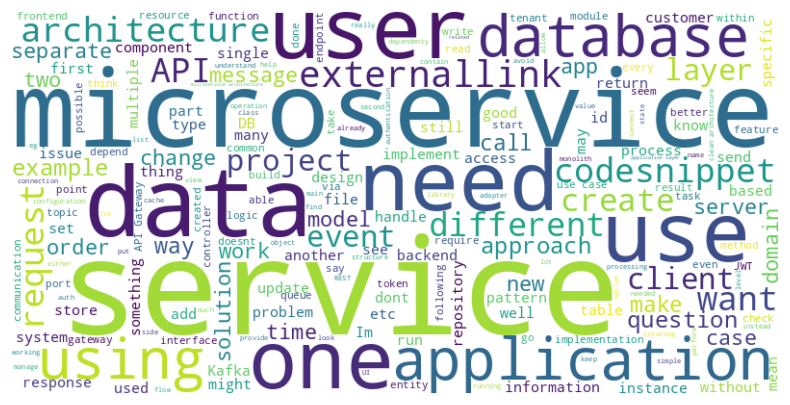

In [ ]:
import pandas as pd
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Load dataset
#df = pd.read_excel('ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.xlsx')

# Replace NaN with empty strings
df['Issue_Extracted'] = df['Issue_Extracted'].fillna("")
df['Solution_Extracted'] = df['Solution_Extracted'].fillna("")

# Combine issues and solutions into one large text string
combined_text = " ".join(df['Issue_Extracted'].tolist() +
                         df['Solution_Extracted'].tolist())

# Define stopwords
stop_words = set(stopwords.words('english')).union({
    "the", "a", "an", "is", "it", "and", "to", "of", "in", "for", "code", "snippet", "link", "extern"
})

# Preprocessing function
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return " ".join(filtered_words)

# Preprocess text
processed_text = preprocess_text(combined_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
from google.colab import files
import nbformat

# Step 1: Upload the broken notebook
uploaded = files.upload()

# Step 2: Process the file
for fname in uploaded.keys():
    # Load the notebook
    nb = nbformat.read(fname, as_version=nbformat.NO_CONVERT)

    # Fix/remove problematic metadata
    if 'widgets' in nb['metadata']:
        print(f"Removing 'metadata.widgets' from {fname}")
        del nb['metadata']['widgets']

    # Save the fixed notebook
    fixed_fname = fname.replace(".ipynb", "_fixed.ipynb")
    nbformat.write(nb, fixed_fname)

    # Download the cleaned file
    files.download(fixed_fname)


Saving ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.ipynb to ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.ipynb
Removing 'metadata.widgets' from ArchISPE_BERTOverflow_TextCNN_Domain_Heuristics_Features.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>